In [1]:
!pip install -q -U "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow-datasets 4.9.4 requires protobuf>=3.20, but you ha

In [4]:
import tensorflow as tf
import tensorflow_text as text

In [13]:
import tensorflow_hub as hub

In [3]:
import datetime
import shutil

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.cloud import aiplatform
!pip install tf-models-official

from official.nlp import optimization  # to

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 67.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=c4305b4bc750134734650eac0a3dbe2db93ba2f13cf8bf36ac3c14333f9967e2
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [6]:
df = pd.read_csv('sentiment_integrado.csv')
df.head(10)

,Unnamed: 0,id,texto,sentimiento,Cantidad palabras,cant caracteres especiales,cant menciones,cant hashtags
0,0,142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",Indefinido,8,4,0,1
1,1,142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,Neutral,10,2,1,0
2,2,142391947707940864,@marodriguezb Gracias MAR,Positivo,3,0,1,0
3,3,142416095012339712,"Off pensando en el regalito Sinde, la que se v...",Negativo,24,4,0,0
4,4,142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,Positivo,15,2,0,0
5,5,142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",Indefinido,16,6,2,0
6,6,142483342040907776,Toca @crackoviadeTV3 . Grabación dl especial N...,Positivo,8,5,1,0
7,7,142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,Indefinido,16,1,0,0
8,8,142494476051562496,Buen día todos! Lo primero mandar un abrazo gr...,Positivo,25,2,1,0
9,9,142496796416016384,Desde el escaño. Todo listo para empezar #endi...,Positivo,12,6,0,1


In [7]:
df_final = df[['sentimiento', 'texto']].dropna(subset=['texto'])

print("Dimensiones de df_final:", df_final.shape)

Dimensiones de df_final: (17069, 2)


In [8]:
# Divide el conjunto de datos en entrenamiento (60%), prueba (20%) y validación (20%)
from sklearn.model_selection import train_test_split
train_df, test_valid_data = train_test_split(df_final, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(test_valid_data, test_size=0.5, random_state=42)

# Imprime el tamaño de cada conjunto
print("Tamaño del conjunto de entrenamiento:", len(train_df))
print("Tamaño del conjunto de prueba:", len(test_df))
print("Tamaño del conjunto de validación:", len(val_df))

Tamaño del conjunto de entrenamiento: 10241
Tamaño del conjunto de prueba: 3414
Tamaño del conjunto de validación: 3414


### Transformo dataset de Pandas a Tensorflow

In [9]:
def pandas_to_tensorflow_dataset(df, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((df['texto'].values, df['sentimiento'].values))
    dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)
    return dataset

In [10]:
batch_size = 32

train_ds = pandas_to_tensorflow_dataset(train_df, batch_size=batch_size)
test_ds = pandas_to_tensorflow_dataset(test_df, batch_size=batch_size)
val_ds = pandas_to_tensorflow_dataset(val_df, batch_size=batch_size)

In [11]:
# defining the URL of the smallBERT model to use
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = (
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [14]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [15]:
text_test = ["La tierra es plana!"]
text_preprocessed = bert_preprocess_model(text_test)

print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids is the ids for the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# 2. input_mask is the tokens which we are masking (masked language model)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

# 3. input_type_ids is the sentence id of the input sentence.
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2474 7563 2527 9686 2933 2050  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


# Usando el modelo BERT

In [16]:

bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [17]:
bert_results = bert_model(text_preprocessed)

print(f"Loaded BERT: {tfhub_handle_encoder}")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9496846   0.98324823 -0.09531265  0.24096364  0.6969304   0.98767346
  0.9986549  -0.8058002  -0.30446488 -0.9985025  -0.08893251 -0.9096693 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.25182402  0.19616833  0.23367709 ... -0.3052696   0.61161005
  -0.3047696 ]
 [ 0.07158667  0.10784472 -0.545988   ... -0.29819494 -0.7554951
   0.02841296]
 [-0.5736358  -0.30087325 -0.29557502 ... -1.101514    0.26085126
  -1.0392197 ]
 ...
 [ 0.22553724  0.11912782  0.09108297 ... -0.2552132   0.9857911
   0.18620631]
 [ 0.2454565   0.02727201 -0.09477063 ... -0.14836322  1.1082826
   0.10798153]
 [-0.5211894  -0.03754289  0.18009949 ... -0.12720661  0.63493353
  -0.02391947]]


In [18]:
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="Texto")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder"
    )
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net)
    return tf.keras.Model(text_input, net)



In [19]:

# Let's check that the model runs with the output of the preprocessing model.
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.25520334]], shape=(1, 1), dtype=float32)


# El modelo tiene la siguiente estructura


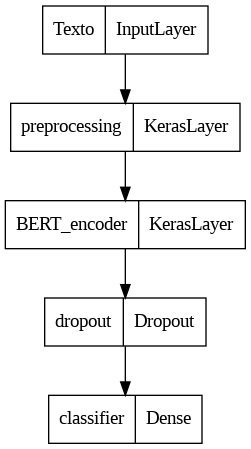

In [20]:
tf.keras.utils.plot_model(classifier_model)

# Loss Function

In [21]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

# Optimizer

Para realizar ajustes, usaremos el optimizador con el que se entrenó originalmente a BERT: Adam optimizart. Este optimizador minimiza la pérdida de predicción y realiza la regularización mediante disminución de peso.

In [22]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

# Cargando el Modelo BERT y entrenandolo

In [23]:

classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)